In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import os
from read_O3_LVK_results import *

In [2]:
precomputed_data = "stored_lnm_q_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    ms = traces['ms']
    qs = traces['qs']
    dR_dlnm1s_q1 = traces['dR_dlnm1s_q1']
    dR_dqs_lnm20 = traces['dR_dqs_lnm20']
    f_lnms = traces['f_lnms']
    f_qs = traces['f_qs']
    R_ref = traces['R_ref'],
    f_q1 = traces['f_q1'],
    f_m20 = traces['f_m20']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_lnm_q.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    lnm_q_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_lnm_q_data.npy',allow_pickle=True)[()]
    m_values = np.exp(lnm_q_data['lnm_allSamples'])
    q_values = lnm_q_data['q_allSamples']

    # For ease of plotting, coarse-grain by a factor of 50
    ms = np.array(m_values[::50])
    f_lnms = np.array(samps['f_lnms'][::50,:])
    qs = np.array(q_values[::50])
    f_qs = np.array(samps['f_qs'][::50])
    R_ref = np.array(samps['R20'])
    f_q1 = np.array(samps['f_qs'][-1,:])
    f_m20 = np.array(samps['f_lnms'][lnm_q_data['ind_m20'],:])

    # Compute rate density over m1, at fixed q=1
    dR_dlnm1s_q1 = np.zeros((ms.size,f_lnms.shape[1]))
    q=1.
    for i in range(f_lnms.shape[1]):
        dR_dlnm1s_q1[:,i] = (R_ref[i]/q)*f_lnms[:,i]*f_lnms[:,i]*f_q1[i]

    # Compute rate density over m1, at fixed q=1
    dR_dqs_lnm20 = np.zeros((qs.size,f_qs.shape[1]))
    for i in range(f_qs.shape[1]):

        f_lnm2 = np.interp(np.log(20.*qs),np.log(ms),f_lnms[:,i])
        dR_dqs_lnm20[:,i] = (R_ref[i]/qs)*f_m20[i]*f_lnm2*f_qs[:,i]

    traces = {
        'qs':qs,
        'ms':ms,
        'dR_dlnm1s_q1':dR_dlnm1s_q1,
        'dR_dqs_lnm20':dR_dqs_lnm20,
        'f_lnms':f_lnms,
        'f_qs':f_qs,
        'R_ref':R_ref,
        'f_q1':f_q1,
        'f_m20':f_m20
        }

    np.save('stored_lnm_q_data.npy',traces)

In [3]:
lvk_m1_grid,lvk_q_grid,lvk_R_m1s_qs = get_lvk_m1_q(300)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:56: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:61: RuntimeWarning: invalid value encountered in true_divide
  p_q_unnormed /= np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:59: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:59: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3

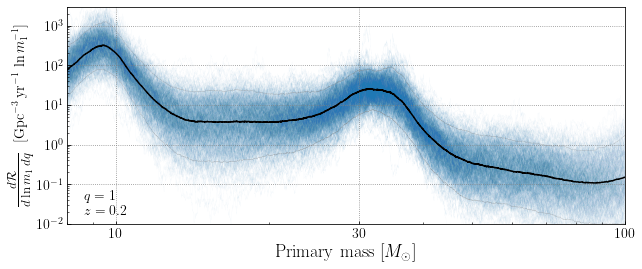

In [3]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)
      
for i in np.random.choice(range(dR_dlnm1s_q1.shape[1]),size=500,replace=False):                 
    ax.plot(ms,dR_dlnm1s_q1[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(ms,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.plot(ms,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='grey',lw=0.15)
ax.plot(ms,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=19)

plt.savefig('lnm1_pp.pdf',bbox_inches='tight',dpi=200)
plt.show()

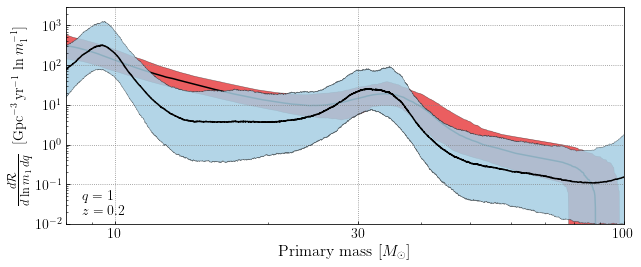

In [9]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

ax.plot(ms,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.fill_between(ms,np.quantile(dR_dlnm1s_q1,0.05,axis=1),np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

ax.plot(lvk_m1_grid,np.median(lvk_R_m1s_qs[:,-1,:],axis=0)*lvk_m1_grid,color='black',zorder=-1)
ax.fill_between(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(ms,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(ms,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('lnm1_pp_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

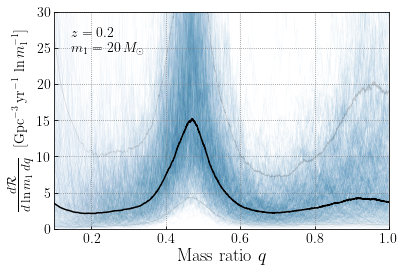

In [10]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=19)

plt.savefig('q_pp_rate.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [14]:
ms = traces['ms']
qs = traces['qs']
dR_dlnm1s_q1 = traces['dR_dlnm1s_q1']
dR_dqs_lnm20 = traces['dR_dqs_lnm20']
f_lnms = traces['f_lnms']
f_qs = traces['f_qs']
f_q1 = f_qs[-1,:]
ind_m20 = np.argmin(np.abs(ms-20.))
f_m20 = np.array(f_lnms[ind_m20,:])

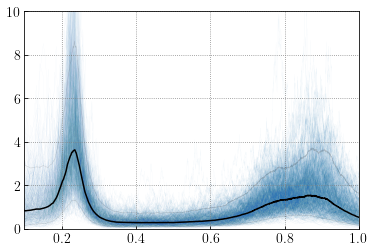

In [25]:
# Compute rate density over m1, at fixed q=1
dR_dqs_lnm20 = np.zeros((qs.size,f_qs.shape[1]))

m = 40.
ind_m = np.argmin(np.abs(ms-m))
f_m = np.array(f_lnms[ind_m,:])

for i in range(f_qs.shape[1]):

    f_lnm2 = np.interp(np.log(m*qs),np.log(ms),f_lnms[:,i])
    dR_dqs_lnm20[:,i] = (1./qs)*f_m[i]*f_lnm2*f_qs[:,i]
    dR_dqs_lnm20[:,i] /= np.trapz(dR_dqs_lnm20[:,i],qs)
    
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,10)
plt.show()

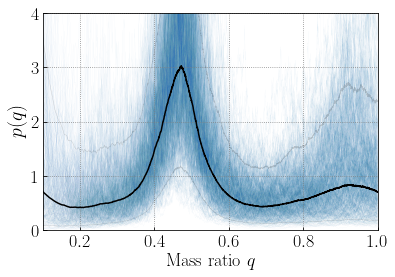

In [11]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

p_qs = dR_dqs_lnm20/np.trapz(dR_dqs_lnm20,qs,axis=0)

for i in np.random.choice(range(p_qs.shape[1]),size=500,replace=False):                 
    ax.plot(qs,p_qs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,4)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q_pp.pdf',bbox_inches='tight',dpi=200)
plt.show()

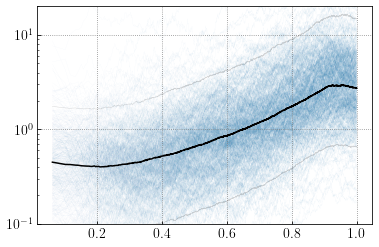

In [6]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

p_qs = f_qs#/np.trapz(f_qs,qs,axis=0)

for i in np.random.choice(range(p_qs.shape[1]),size=500,replace=False):                 
    ax.plot(qs,p_qs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.set_ylim(1e-1,20)
ax.set_yscale('log')

R(a1,a2) = f(a1|MU,SIGMA) f(a2|MU,SIGMA) g(a1-a2|mu,sigma)

(0.0, 15.0)

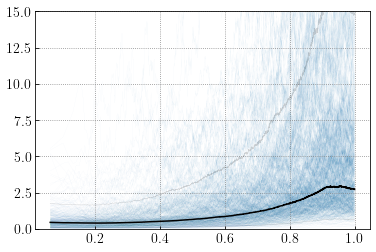

In [7]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

p_qs = f_qs#/np.trapz(f_qs,qs,axis=0)

for i in np.random.choice(range(p_qs.shape[1]),size=500,replace=False):                 
    ax.plot(qs,p_qs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.set_ylim(0,15)

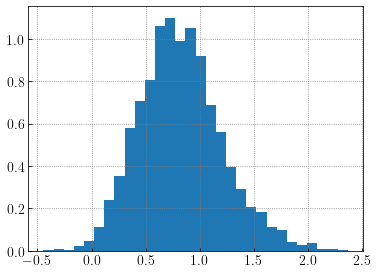

In [9]:
f_low = f_qs[0,:]
f_high = f_qs[-1,:]

plt.hist(np.log10(f_high/f_low),bins=30,density=True)
plt.show()

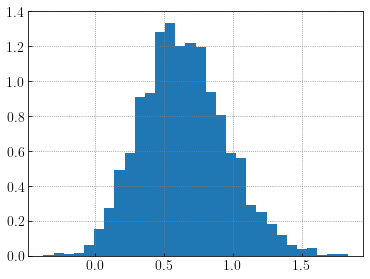

In [15]:
ind_q05 = np.argmin(np.abs(qs-0.5))

f_low = f_qs[ind_q05,:]
f_high = f_qs[-1,:]

plt.hist(np.log10(f_high/f_low),bins=30,density=True)
plt.show()